In [1]:
import cartopy.crs
import emsarray.plot
import numpy
import xarray
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

dataset = emsarray.open_dataset("https://dapds00.nci.org.au/thredds/dodsC/fx3/model_data/gbr4_bgc_GBR4_H2p0_B2p0_Chyd_Dcrt.ncml")

# Select the latest time step
dataset = dataset.isel(time=-1)

In [2]:
def reflectance_to_rgb(
    r_645: numpy.ndarray,
    r_555: numpy.ndarray,
    r_470: numpy.ndarray,
    *,
    bright_factor: float = 12.5,
    desaturate_factor: float = 0.6,
) -> numpy.ndarray:
    """
    Take an array of radiance values and transform it in to true colour.
    The colours are ramped a bit, desatureated, etc.

    Parameters
    ----------
    r_645, r_555, r_470 : numpy.ndarray
        Arrays representing the surface reflectance (radiance?)
        in wavelengths of 645 nm, 555 nm, and 470 nm respectively.
        The arrays must be the same shape,
        but can have any number of axes.
    bright_factor : float
        A multiplier that increases the brightness of the image.
        Higher numbers are brighter.

    Returns
    -------
    rgb: numpy.ndarray
        An array the same shape as the input arrays
        except for one extra axis of length 3.
        The final axis represents RGB values suitable for plotting.
        The values will be between 0 and 1.
    """

    # setup our rgb array using the 3 vars
    rgb = numpy.stack([r_645, r_555, r_470], axis=-1)
    rgb = numpy.nan_to_num(rgb, nan=1)

    # Some colour ramps
    in_scale = numpy.array([0,  30,  60, 120, 190, 255], dtype=numpy.float64)
    out_scale = numpy.array([0, 130, 160, 210, 240, 255], dtype=numpy.float64)

    # I'm pulling the green channel down a bit
    # as it looks more saturated than example
    g_scale = out_scale - 50
    g_scale[0] = 0
    g_scale[5] = 255

    in_scale = in_scale / 255.
    out_scale = out_scale / 255.
    g_scale = g_scale / 255.

    # apply color channel enhancement
    rgb[..., 0] = interp1d(in_scale, out_scale)(rgb[..., 0])
    rgb[..., 1] = interp1d(in_scale, g_scale)(rgb[..., 1])
    rgb[..., 2] = interp1d(in_scale, out_scale)(rgb[..., 2])

    # turn brightness back up a bit
    brighter = rgb * bright_factor

    # Desaturate the image a bit by blending with a greyscale copy.
    # The particulars here are how Pillows ImageEnhance.Color class operates.
    #
    # Convert to greyscale using the ITU-R 601-2 luma transform.
    greyscale_value = (
        brighter[..., 0] * 299/1000
        + brighter[..., 1] * 587/1000
        + brighter[..., 2] * 114/1000
    )
    greyscale = numpy.stack([greyscale_value] * 3, axis=-1)
    # Blend with the original to get a desaturated image
    desaturate_factor = 0.6
    rgb = brighter * desaturate_factor + greyscale * (1 - desaturate_factor)

    # Clip the values to the [0..1] interval
    rgb = numpy.clip(rgb, 0, 1)

    # Done!
    return rgb

Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #95 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included but were encoded as GeoJSON exterior rings instead of holes.
Possible issue encountered when converting Shape #491 to GeoJSON: Shapefile format requires that polygons contain at least one exterior ring, but the Shape was entirely made up of interior holes (defined by counter-clockwise orientation in the shapefile format). The rings were still included b

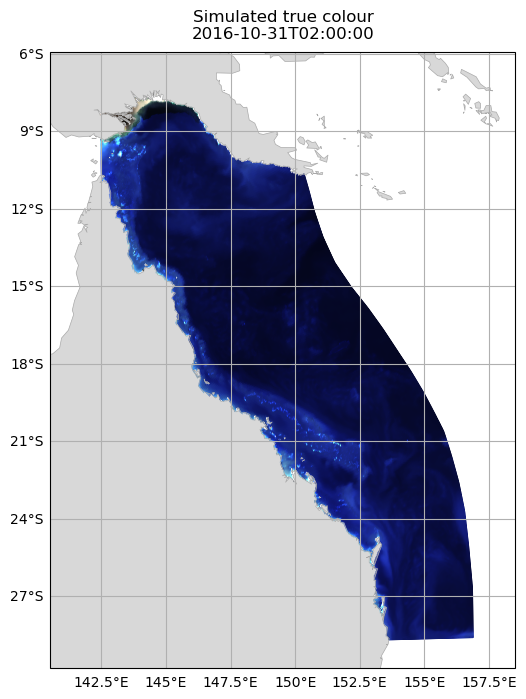

In [3]:
fig = plt.figure(figsize=(6, 8))
axes = fig.add_subplot(projection=cartopy.crs.PlateCarree())
axes.set_aspect(aspect='equal', adjustable='datalim')

plt.title(f"Simulated true colour\n{numpy.datetime_as_string(dataset['time'].values, 's')}")

rgb_values = reflectance_to_rgb(
    dataset.ems.ravel(dataset['R_645']),
    dataset.ems.ravel(dataset['R_555']),
    dataset.ems.ravel(dataset['R_470']),
)
rgb_values = rgb_values[dataset.ems.mask]

axes.add_collection(dataset.ems.make_poly_collection(color=rgb_values))
emsarray.plot.add_coast(axes)
axes.gridlines(draw_labels=['left', 'bottom'])
axes.autoscale()

plt.show()